In [1]:
# imports
import os, glob, pickle, random

import numpy as np  
import matplotlib.pyplot as plt
import matplotlib.style as style

import seaborn as sns

style.use('seaborn-whitegrid')
sns.set_palette("muted", 10)
sns.set()

In [5]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#DataFlair - Emotions to observe
observed_emotions=['happy','sad','angry','fearful','disgust','surprised']

In [6]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
import librosa
import soundfile

SAMPLERATE = 16000 # Hz

def extract_feature(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        sample_rate=sound_file.samplerate
        X = sound_file.read(dtype="float32")
        if sample_rate != SAMPLERATE:
            X = librosa.resample(X, sample_rate, SAMPLERATE)
            sample_rate=SAMPLERATE 
        #print('filename=', file_name, ' samplerate=', sample_rate)        
        stft=np.abs(librosa.stft(X))
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=X, sr=sample_rate).T, axis=0)
        bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
        flatness = np.mean(librosa.feature.spectral_flatness(y=X))
        contrast = np.mean(librosa.feature.spectral_contrast(y=X))
        result = np.hstack((mfccs, chroma, mel, tonnetz, bandwidth, flatness, contrast))
    return (X, result)

In [7]:
#DataFlair - Load the data and extract features for each sound file
from tqdm.autonotebook import tqdm
cwd = os.getcwd()

def load_data(glob_pattern=cwd+"/dataset2/Actor_*/*.wav"):
    X,x,y=[],[],[]
    for file in tqdm(glob.glob(glob_pattern)):
        file_name=os.path.basename(file)
        if file_name.split("-")[2] == '01' or file_name.split("-")[2] == '02':
            continue
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        Xo, feature=extract_feature(file)
        X.append(Xo)
        x.append(feature)
        y.append(emotion)
    return X,x,y

In [64]:
X,x,y = load_data()

100%|██████████| 5332/5332 [05:54<00:00, 15.05it/s]


In [65]:
pickle.dump(X, open("combined-wavs2.pickle", "wb"))
pickle.dump((x,y), open("extracted-data.pickle", "wb"))

In [8]:
x,y = pickle.load(open("extracted-data2.pickle", "rb" ))

In [11]:
import librosa.display

def plot_emo_specs(x,y,emos,n):
    index = 1
    nemos = len(emos)
    emo_data = dict()
    
    plt.figure()
    fig, axs = plt.subplots(nemos, n, figsize=(n*4,nemos*3), sharey=True,
                        gridspec_kw={'wspace': 0.01, 'hspace': 0.15})
    axs = axs.flatten()
    props = dict(boxstyle='round', facecolor='white', alpha=0.95)
    
    for emo in observed_emotions:
        xys = [xyi for xyi in zip(x, y) if xyi[1] == emo]
        emo_data[emo] = random.sample(xys, n)
        
        for i, samp in enumerate(emo_data[emo]):
            M = librosa.feature.melspectrogram(y=samp[0])
            ax = axs[index-1]
            librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', ax=ax)
            
            if (index-1) % n == 0:
                ax.text(0.05, 0.95, emo.capitalize(), 
                transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
            
            index += 1
    
    plt.tight_layout()        
    plt.show()

<Figure size 432x288 with 0 Axes>

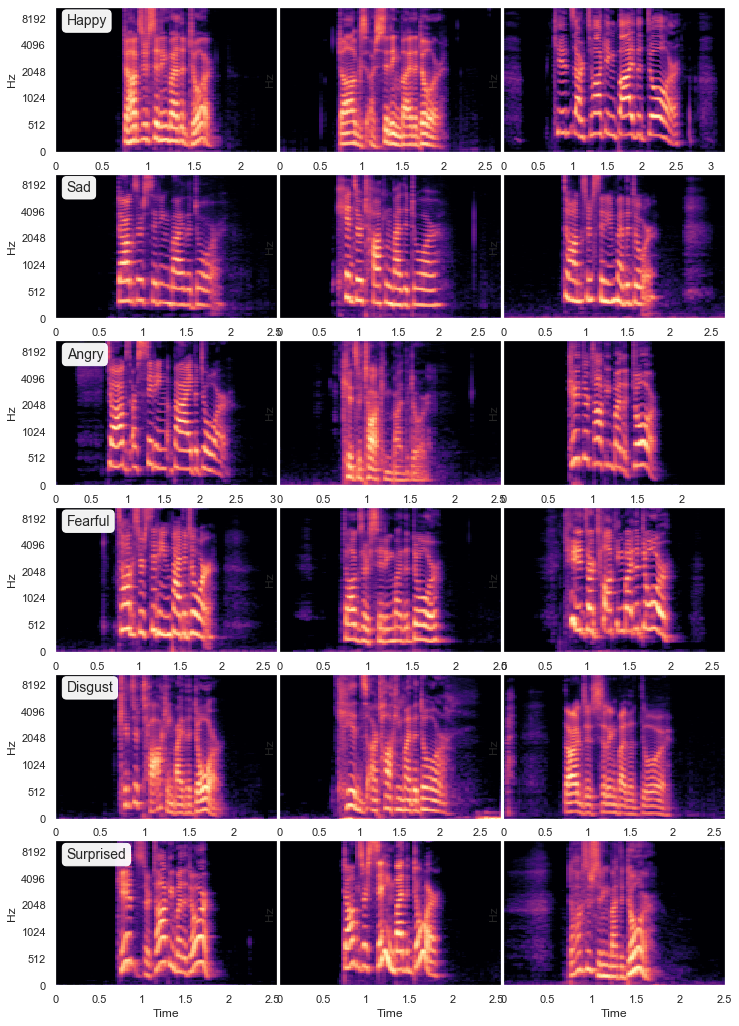

In [12]:
plot_emo_specs(X,y,observed_emotions, n=3)

In [9]:
from sklearn.model_selection import train_test_split

random.seed(1)
np.random.seed(1)
#DataFlair - Split the dataset
x_train_strat,x_test_strat,y_train_strat,y_test_strat = train_test_split(np.array(x), y, test_size=0.2, 
                                                                        random_state=1, stratify=y)
random.seed(1)
np.random.seed(1)
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test = train_test_split(np.array(x), y, test_size=0.2, random_state=1)

In [144]:
#DataFlair - Get the shape of the training and testing datasets
print((x_train_strat.shape[0], x_test_strat.shape[0]))
print((x_train.shape[0], x_test.shape[0]))

(921, 231)
(921, 231)


In [145]:
#DataFlair - Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 189


In [10]:
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [12]:
# Classifiers - MLP, K-Nearest Neighbor, Support Vector Machine and Decision Tree Classifier

mlp = MLPClassifier(alpha=0.01, batch_size=128, epsilon=1e-08, hidden_layer_sizes=(500,250,125,), learning_rate='adaptive', max_iter=2500)
# n=20 seems to be optimal
knn = neighbors.KNeighborsClassifier(20)
svm_clf = svm.SVC()
dtc = tree.DecisionTreeClassifier(max_depth=4)
nb = naive_bayes.GaussianNB()

# Newton-cg handles multinomial loss (for multiclass problems)
lr = linear_model.LogisticRegression(solver='newton-cg')

# Cross Validation using K-Fold
random.seed(1)
np.random.seed(1)
kf5 = KFold(n_splits=5, random_state=1)
random.seed(1)
np.random.seed(1)
skf5 = StratifiedKFold(n_splits=5, random_state=1)
random.seed(1)
np.random.seed(1)
kf10 = KFold(n_splits=10, random_state=1)
random.seed(1)
np.random.seed(1)
skf10 = StratifiedKFold(n_splits=10, random_state=1)

In [12]:
import pandas as pd

In [13]:

models = [("MLP", mlp), ("K-NearestNeighbors", knn), ("SupportVectorMachine", svm_clf),
          ("DecisionTreeClassifier", dtc), ("NaiveBayesGaussian", nb), ("LogisticRegression", lr)]
# validators = [("5-fold", kf5),  ("Stratified 5-fold", skf5)]
# or all validators?
validators = [("5-fold", kf5),  ("Stratified 5-fold", skf5), ("10-fold", kf10), ("Stratified 10-fold", skf10)]
val_res = {}

for name, validator in validators:
    val_res[name] = {}
    entries = []
    for model_name, model in tqdm(models, desc=name):
        random.seed(0)
        np.random.seed(0)
        # Scores of all folds per model
        scores = cross_val_score(model, x_train_strat, y_train_strat, cv=validator)
        val_res[name][model_name] = scores
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))
    val_res[name] = pd.DataFrame(entries, columns=['clf_name', 'fold_idx', 'accuracy'])

Stratified 10-fold:  83%|████████▎ | 5/6 [08:11<01:49, 109.56s/it]

<Figure size 640x480 with 0 Axes>

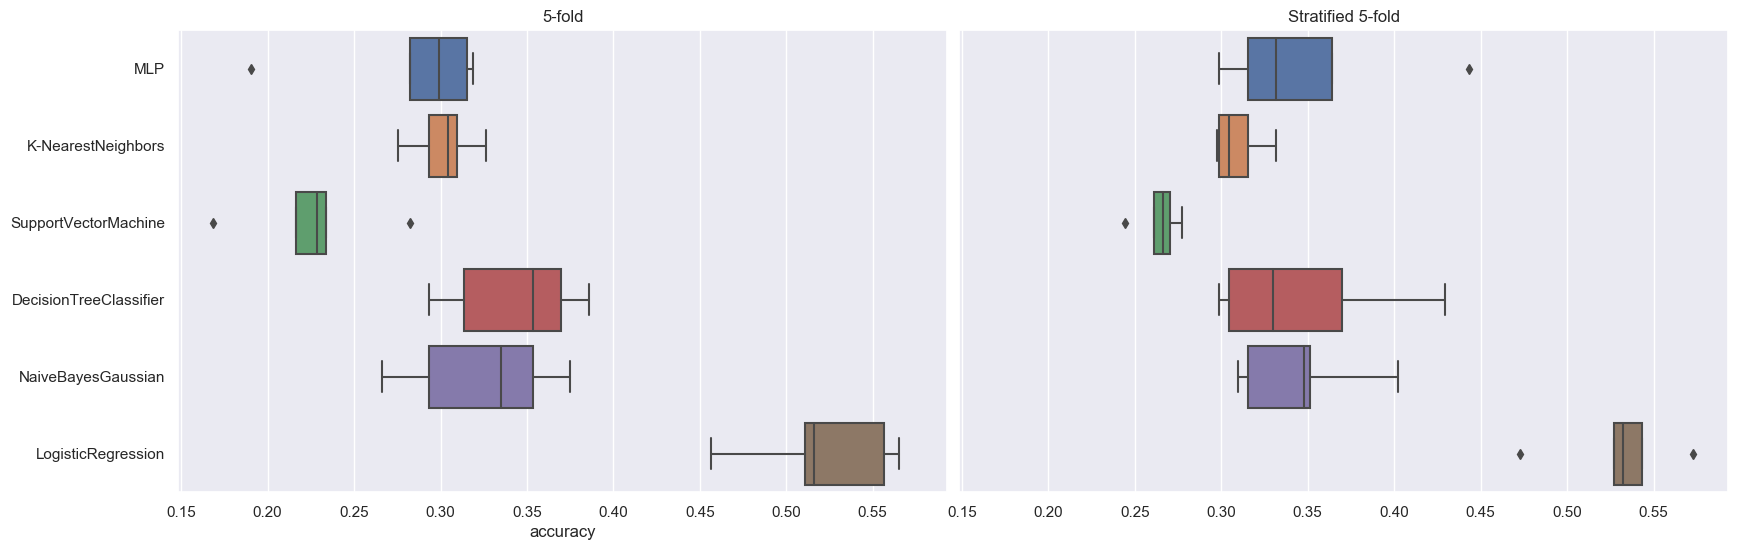

In [162]:
style.use('seaborn-whitegrid')
sns.set_palette("muted", 10)
sns.set()

fig = plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey=True, sharex=True,
                        gridspec_kw={'wspace': 0.015, 'hspace': 0.15})

sns.boxplot(x='accuracy', y='clf_name', data=val_res['5-fold'], ax=axs[0])
axs[0].set_title('5-fold')
axs[0].yaxis.label.set_visible(False)

sns.boxplot(x='accuracy', y='clf_name', data=val_res['Stratified 5-fold'], ax=axs[1])
axs[1].set_title('Stratified 5-fold')
axs[1].yaxis.label.set_visible(False)
axs[1].xaxis.label.set_visible(False)
plt.show()

<Figure size 640x480 with 0 Axes>

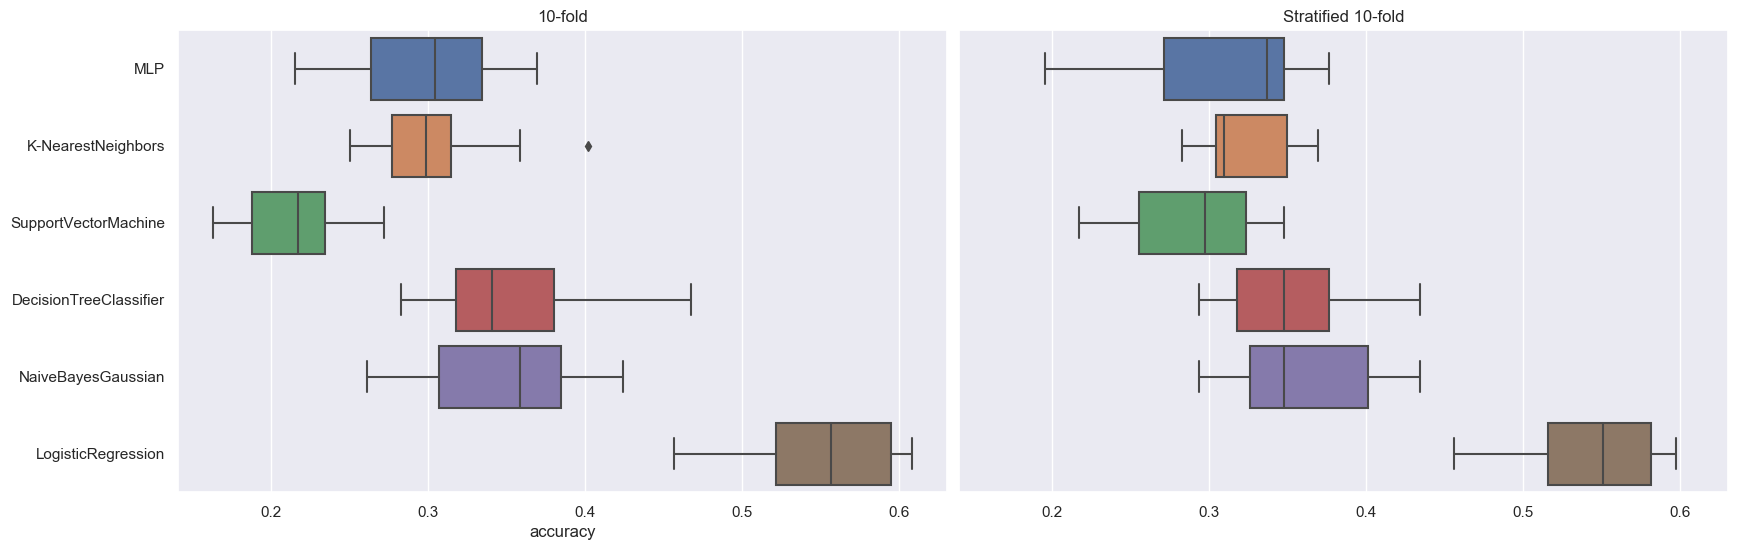

In [163]:
fig = plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey=True, sharex=True,
                        gridspec_kw={'wspace': 0.015, 'hspace': 0.15})

sns.boxplot(x='accuracy', y='clf_name', data=val_res['10-fold'], ax=axs[0])
axs[0].set_title('10-fold')
axs[0].yaxis.label.set_visible(False)
sns.boxplot(x='accuracy', y='clf_name', data=val_res['Stratified 10-fold'], ax=axs[1])
axs[1].set_title('Stratified 10-fold')
axs[1].yaxis.label.set_visible(False)
axs[1].xaxis.label.set_visible(False)
plt.show()

In [164]:
print("5-FOLD CV ====================================================")
print(val_res['5-fold'].groupby('clf_name').accuracy.describe()[['mean', 'std', 'min', 'max']])
print("STRAT 5-FOLD CV ==============================================")
print(val_res['Stratified 5-fold'].groupby('clf_name').accuracy.describe()[['mean', 'std', 'min', 'max']])
print("10-FOLD CV ===================================================")
print(val_res['10-fold'].groupby('clf_name').accuracy.describe()[['mean', 'std', 'min', 'max']])
print("STRAT 10-FOLD CV =============================================")
print(val_res['Stratified 10-fold'].groupby('clf_name').accuracy.describe()[['mean', 'std', 'min', 'max']])

5-FOLD CV ====================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.343137  0.038635  0.293478  0.385870
K-NearestNeighbors      0.301874  0.018787  0.275676  0.326087
LogisticRegression      0.521134  0.043347  0.456522  0.565217
MLP                     0.281175  0.052852  0.190217  0.318919
NaiveBayesGaussian      0.324636  0.044271  0.266304  0.375000
SupportVectorMachine    0.225852  0.040845  0.168478  0.282609
STRAT 5-FOLD CV ==============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.346381  0.054125  0.298913  0.429348
K-NearestNeighbors      0.309459  0.014188  0.297297  0.331522
LogisticRegression      0.529812  0.036441  0.472826  0.572973
MLP                     0.350605  0.057126  0.298913  0

### Stratified train-test split (8:2)

```
5-FOLD CV ====================================================
                            mean       std       min       max
DecisionTreeClassifier  0.343137  0.038635  0.293478  0.385870
K-NearestNeighbors      0.301874  0.018787  0.275676  0.326087
LogisticRegression      0.521134  0.043347  0.456522  0.565217
MLP                     0.281175  0.052852  0.190217  0.318919
NaiveBayesGaussian      0.324636  0.044271  0.266304  0.375000
SupportVectorMachine    0.225852  0.040845  0.168478  0.282609

STRAT 5-FOLD CV ==============================================
                            mean       std       min       max
DecisionTreeClassifier  0.346381  0.054125  0.298913  0.429348
K-NearestNeighbors      0.309459  0.014188  0.297297  0.331522
LogisticRegression      0.529812  0.036441  0.472826  0.572973
MLP                     0.350605  0.057126  0.298913  0.443243
NaiveBayesGaussian      0.345270  0.036892  0.309783  0.402174
SupportVectorMachine    0.263837  0.012304  0.244565  0.277174

10-FOLD CV ===================================================
                            mean       std       min       max
DecisionTreeClassifier  0.351800  0.054563  0.282609  0.467391
K-NearestNeighbors      0.306183  0.045714  0.250000  0.402174
LogisticRegression      0.549392  0.051126  0.456522  0.608696
MLP                     0.296505  0.048783  0.215054  0.369565
NaiveBayesGaussian      0.347429  0.055027  0.260870  0.423913
SupportVectorMachine    0.216047  0.035120  0.163043  0.271739

STRAT 10-FOLD CV =============================================
                            mean       std       min       max
DecisionTreeClassifier  0.353950  0.047998  0.293478  0.434783
K-NearestNeighbors      0.321388  0.030365  0.282609  0.369565
LogisticRegression      0.541784  0.050573  0.456522  0.597826
MLP                     0.307200  0.061186  0.195652  0.376344
NaiveBayesGaussian      0.357165  0.050320  0.293478  0.434783
SupportVectorMachine    0.286629  0.046047  0.217391  0.347826
```

### Regular train-test split (8:2)

```
5-FOLD CV ====================================================
                            mean       std       min       max
DecisionTreeClassifier  0.370217  0.050859  0.293478  0.429348
K-NearestNeighbors      0.318102  0.018342  0.298913  0.345946
LogisticRegression      0.545041  0.012572  0.532609  0.562162
MLP                     0.296322  0.075146  0.184783  0.383784
NaiveBayesGaussian      0.314841  0.023681  0.288043  0.345946
SupportVectorMachine    0.234489  0.034499  0.184783  0.270270

STRAT 5-FOLD CV ==============================================
                            mean       std       min       max
DecisionTreeClassifier  0.374536  0.045601  0.309783  0.427027
K-NearestNeighbors      0.321328  0.032008  0.304348  0.378378
LogisticRegression      0.551533  0.039074  0.500000  0.592391
MLP                     0.332239  0.068080  0.244565  0.429348
NaiveBayesGaussian      0.310482  0.029346  0.282609  0.356757
SupportVectorMachine    0.265981  0.029581  0.233696  0.297297

10-FOLD CV ===================================================
                            mean       std       min       max
DecisionTreeClassifier  0.397312  0.053447  0.315217  0.473118
K-NearestNeighbors      0.343069  0.041936  0.282609  0.413043
LogisticRegression      0.533018  0.054727  0.456522  0.623656
MLP                     0.322370  0.085928  0.184783  0.434783
NaiveBayesGaussian      0.310531  0.043815  0.239130  0.380435
SupportVectorMachine    0.239902  0.033626  0.195652  0.293478

STRAT 10-FOLD CV =============================================
                            mean       std       min       max
DecisionTreeClassifier  0.369133  0.035455  0.315217  0.423913
K-NearestNeighbors      0.352828  0.029671  0.304348  0.397849
LogisticRegression      0.542847  0.045204  0.423913  0.580645
MLP                     0.318093  0.080333  0.195652  0.423913
NaiveBayesGaussian      0.313756  0.047362  0.239130  0.402174
SupportVectorMachine    0.262763  0.025040  0.217391  0.304348
```

In [1]:
#NON-NORMALIZED
dt_scores = [0.370217, 0.374536, 0.397312, 0.369133]
knn_scores = [0.318102, 0.321328, 0.343069, 0.352828]
lr_scores = [0.545041, 0.551533, 0.533018, 0.542847]
mlp_scores = [0.296322, 0.332239, 0.322370, 0.318093]
nb_scores = [0.314841, 0.310482, 0.310531, 0.313756]
svm_scores = [0.234489, 0.265981, 0.239902, 0.262763]

dts_scores = [0.343137, 0.346381, 0.351800, 0.353950]
knns_scores = [0.301874, 0.309459, 0.306183, 0.321388]
lrs_scores = [0.521134, 0.529812,  0.549392, 0.541784]
mlps_scores = [0.281175, 0.350605, 0.296505, 0.307200]
nbs_scores = [0.324636, 0.345270, 0.347429, 0.357165]
svms_scores = [0.225852, 0.263837, 0.216047, 0.286629] 

#NORMALIZED
dt_scores_n = [0.308343, 0.322479, 0.326788, 0.326788]
knn_scores_n = [0.407192, 0.395235, 0.421295,  0.400655]
lr_scores_n = [0.362573,  0.369095,  0.371248, 0.373422]
mlp_scores_n = [0.600452,  0.561340,  0.603682,  0.590615]
nb_scores_n = [0.410429,  0.408273,  0.403939,  0.399603]
svm_scores_n = [0.514653,  0.527685, 0.520056,  0.525526]

                                            
dts_scores_n = [0.295311, 0.299618, 0.300736, 0.342052]
knns_scores_n = [0.409365, 0.414777, 0.419074, 0.422288]
lrs_scores_n = [0.347409, 0.371322, 0.368093, 0.379991]
mlps_scores_n = [0.564659, 0.567914, 0.566865, 0.567835]
nbs_scores_n = [0.386522, 0.395235, 0.395302, 0.394191]
svms_scores_n = [0.492914, 0.510306, 0.511454, 0.508135]


In [17]:
from scipy import stats
from statsmodels.stats import weightstats as stests

# Regular vs. Stratified train/test split
dt_ttest = {"RS": dt_scores, "SS": dts_scores}
knn_ttest = {"RS": knn_scores, "SS": knns_scores}
lr_ttest = {"RS": lr_scores, "SS": lrs_scores}
mlp_ttest = {"RS": mlp_scores, "SS": mlps_scores}
nb_ttest = {"RS": nb_scores, "SS": nbs_scores}
svm_ttest = {"RS": svm_scores, "SS": svms_scores}

# Regular vs. Normalized Features
dt_ttest_n = {"R": dts_scores, "N": dts_scores_n}
knn_ttest_n = {"R": knns_scores, "N": knns_scores_n}
lr_ttest_n = {"R": lrs_scores, "N": lrs_scores_n}
mlp_ttest_n = {"R": mlps_scores, "N": mlps_scores_n}
nb_ttest_n = {"R": nbs_scores, "N": nbs_scores_n}
svm_ttest_n = {"R": svms_scores, "N": svms_scores_n}

models = [dt_ttest, knn_ttest, lr_ttest, mlp_ttest, nb_ttest, svm_ttest]
normalized_models = [dt_ttest_n, knn_ttest_n, lr_ttest_n, mlp_ttest_n, nb_ttest_n, svm_ttest_n]

names = ["DecisionTree", "K-NearestNeighbors", "LogisticRegression", "MLP",
        "NaiveBayesGaussian", "SupportVectorMachine"]

print("Regular Features:")
for i in range(0, len(models)):
    ttest, pval = stats.ttest_ind(models[i]['SS'], models[i]['RS'])
    print("P-value for significance ({}):".format(names[i]), pval)
    print("TTEST: ", ttest)
    if pval<0.05:
        print("Conclusion: Reject Null Hypothesis")
    else:
        print("Conclusion: Accept Null Hypothesis")

print("NORMALIZED Features:")
for i in range(0, len(normalized_models)):
    ttest, pval = stats.ttest_ind(normalized_models[i]['N'], normalized_models[i]['R'])
    print("P-value for significance ({}):".format(names[i]), pval)
    print("TTEST: ", ttest)

    if pval<0.05:
        print("Conclusion: Reject Null Hypothesis")
    else:
        print("Conclusion: Accept Null Hypothesis")


Regular Features:
P-value for significance (DecisionTree): 0.006303744372285508
TTEST:  -4.10754027651251
Conclusion: Reject Null Hypothesis
P-value for significance (K-NearestNeighbors): 0.04264686229533345
TTEST:  -2.564546235202814
Conclusion: Reject Null Hypothesis
P-value for significance (LogisticRegression): 0.3420529779970899
TTEST:  -1.0315635167388628
Conclusion: Accept Null Hypothesis
P-value for significance (MLP): 0.6338674866372207
TTEST:  -0.5015265519700873
Conclusion: Accept Null Hypothesis
P-value for significance (NaiveBayesGaussian): 0.0040762971084260784
TTEST:  4.506347972127144
Conclusion: Reject Null Hypothesis
P-value for significance (SupportVectorMachine): 0.8877678097920264
TTEST:  -0.14723715771861062
Conclusion: Accept Null Hypothesis
NORMALIZED Features:
P-value for significance (DecisionTree): 0.012631364635713878
TTEST:  -3.5126069327527722
Conclusion: Reject Null Hypothesis
P-value for significance (K-NearestNeighbors): 7.218052445410804e-07
TTEST:  21

```
### Regular Features:
Regular Features:
P-value for significance (DecisionTree): 0.006303744372285508
Conclusion: Reject Null Hypothesis
P-value for significance (K-NearestNeighbors): 0.04264686229533345
Conclusion: Reject Null Hypothesis
P-value for significance (LogisticRegression): 0.3420529779970899
Conclusion: Accept Null Hypothesis
P-value for significance (MLP): 0.6338674866372207
Conclusion: Accept Null Hypothesis
P-value for significance (NaiveBayesGaussian): 0.0040762971084260784
Conclusion: Reject Null Hypothesis
P-value for significance (SupportVectorMachine): 0.8877678097920264
Conclusion: Accept Null Hypothesis
NORMALIZED Features:
P-value for significance (DecisionTree): 0.012631364635713878
Conclusion: Reject Null Hypothesis
P-value for significance (K-NearestNeighbors): 7.218052445410804e-07
Conclusion: Reject Null Hypothesis
P-value for significance (LogisticRegression): 1.8266906268670014e-06
Conclusion: Reject Null Hypothesis
P-value for significance (MLP): 2.3995592816947104e-06
Conclusion: Reject Null Hypothesis
P-value for significance (NaiveBayesGaussian): 0.0004676705634488016
Conclusion: Reject Null Hypothesis
P-value for significance (SupportVectorMachine): 5.2547482663555914e-06
Conclusion: Reject Null Hypothesis

In [72]:
regular_split = {"DecisionTree": dt_scores, "K-NearestNeighbors": knn_scores, "SupportVectorMachine": svm_scores, 
        "MLP": mlp_scores, "NaiveBayesGaussian": nb_scores, "LogisticRegression": lr_scores}

F, p = stats.f_oneway(regular_split['DecisionTree'], regular_split['K-NearestNeighbors'],
        regular_split['SupportVectorMachine'], regular_split['MLP'], regular_split['NaiveBayesGaussian'],
        regular_split['LogisticRegression'])

print("P-value for significance (regular split): ", p)

if p<0.05:
    print("Reject Null Hypothesis")
else:
    print("Accept Null Hypothesis")


P-value for significance (regular split):  7.814578387659082e-16
Reject Null Hypothesis


In [73]:
stratified_split = {"DecisionTree": dts_scores, "K-NearestNeighbors": knns_scores, "SupportVectorMachine": svms_scores, 
        "MLP": mlps_scores, "NaiveBayesGaussian": nbs_scores, "LogisticRegression": lrs_scores}

F, p = stats.f_oneway(stratified_split['DecisionTree'], stratified_split['K-NearestNeighbors'],
    stratified_split['SupportVectorMachine'], stratified_split['MLP'], stratified_split['NaiveBayesGaussian'],               stratified_split['LogisticRegression'])

print("P-value for significance (stratified split): ", p)

if p<0.05:
    print("Reject Null Hypothesis")
else:
    print("Accept Null Hypothesis")


P-value for significance (stratified split):  2.505295545337362e-12
Reject Null Hypothesis


In [ ]:
import pickle
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)
with open('knn.pickle', 'wb') as f:
    pickle.dump(knn, f)

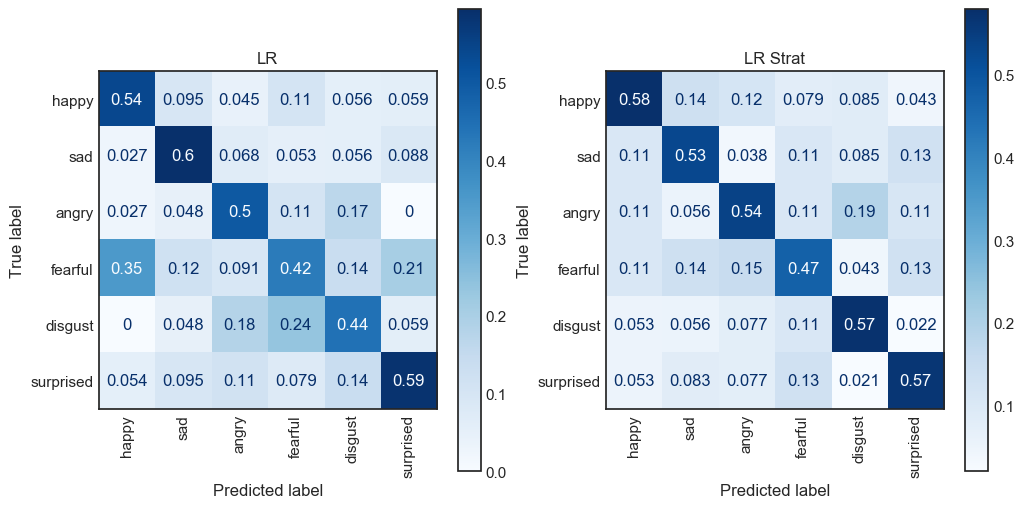

In [167]:
from sklearn.metrics import plot_confusion_matrix
style.use('seaborn-white')

def plot_model_cm(name, model, xtrain, ytrain, xtest, ytest, ax=None):
    random.seed(0)
    np.random.seed(0)
    model.fit(xtrain, ytrain)
    fig = plot_confusion_matrix(model, xtest, ytest,
                      display_labels=observed_emotions,
                      cmap=plt.cm.Blues, xticks_rotation='vertical', 
                      normalize='pred', values_format='.2f', ax=ax)
    fig.ax_.set_title(name)

fig, axs = plt.subplots(1,2, figsize=(12,6))
plot_model_cm("LR", lr, x_train, y_train, x_test, y_test, ax=axs[0])
plot_model_cm("LR Strat", lr, x_train_strat, y_train_strat, x_test_strat, y_test_strat, ax=axs[1])
plt.show()